# Welcome to Daisyworld
**Daisyworld Exercise, Roelof Rietbroek, updated Jan 2020**

Daisyworld [1] is an hypothetical planet which has only 2 types of organisms. white and black daisies. These daisies differ in that they reflect sunlight in different amounts, and one can guess that white daisies reflect sunlight much better than black daisies. Because of these reflection characteristics (albedo) they can alter the climate of the planet given an amount of incoming solar radiation. 

Interestingly, the daisies can reproduce themselves and the rate at which this is happening depends on the local temperature close to the daisies. This creates an interesting feedback mechanism which is going to be studied in this exercise.

## Performing the exercise
This exercise is intended to give you insights in the concepts of albedo , Stefan Boltzmann law and the non-linear systems. Another intention is to allow you to gain some programming experience in python.

This exercise consists of implementing the [Equations of Daisyworld](#the-equations-of-daisyworld), and subsequently executing [2 experiments](#experiments) to see how the planet responds to different forcing.

This exercise can be done in 2 ways. 
1. [Install jupyter](https://jupyter.readthedocs.io/en/latest/install.html) and run/adapt this notebook (recommended)
2. Program the functionality of this exercise in your own language of choice (e.g. matlab/octave/..)

### Installation notes for Windows
To run the code in this notebook one needs to have a fairly recent python (version >= 3) and jupyter notebook installed. 
The easiest way to install python with the [jupyter notebook](https://jupyter.org) is probably to install [anaconda for windows](https://www.anaconda.com/download/#windows).
, which comes with jupyter notebook installed by default. Other ways are also possible (e.g. [install the ubuntu shell in windows 10](https://www.howtogeek.com/249966/how-to-install-and-use-the-linux-bash-shell-on-windows-10/) and consequently install python and jupyter)

### Installation notes for linux
execute in a terminal:

`pip3 install jupyter`


# The Equations of Daisyworld <a name="equations-of-daisyworld"></a>

## Representing the state of the planet
The state of daisyworld can be put in the so called state-vector, $\textbf{x}$:

$$
\textbf{x}=\left[\begin{array}{c}T_{p}\\T_{w}\\T_{b}\\S_{u}\\S_{w}\\S_{b}\\A_{p}\end{array}\right]\begin{array}{c} \text{Temperature of the planet}\\
\text{Local temperature at the white daisies}\\
\text{Local temperature at the black daisies}\\
\text{Uninhabited surface (0..1)}\\
\text{Surface populated by white daisies (0..1)}\\
\text{Surface populated by black daisies(0..1)}\\
\text{Albedo of the planet}\end{array}$$

One aim of the exercise is to write a function [yielding the next state](#update-the-planetary-state-vector), which
depends on the previous one, given a fixed solar flux, $F$, as input:

$\textbf{x}_{i+1}=f(\textbf{x}_{i},F)$. 

The nonlinear function $f$,
contains [4 steps as described below](#building-daisyworld). In this exercise, one may use the
constants as provided in the [table 1](#table-1-daisyworld-constants).


### Table 1: Daisyworld constants
<a name="table-1-daisyworld-constants"></a>

| Parameter  | Value      | Units | Description    |
| :---------- | :----------: | :-----: | :------------------------ |
| $A_{u}$| 0.5 | [-] | Albedo of barren area |
| $A_{w}$| 0.75 | [-] | Albedo of regions with white daisies|
|$A_{b}$| 0.25 | [-] | Albedo of regions with black daisies|
|$\sigma$|5.670373$\cdot10^{-8}$|  $[W m^{-2} K^{-4}]$ | Stefan Boltzmann constant| 
|$c_{ins}$| 0.2 | [-] | Insulation parameter|
|$F_{sun}^{nom}$|3668 | $[Wm^{-2}]$ |  Nominal solar flux at the planet|
|$T_{opt}$| 22.5 | $[^{\circ} C]$ | Optimal growing temperature|
|$T_{min}$| 5 | $[^{\circ} C]$ | Minimum growing temperature|
|$T_{max}$| 40 | $[^{\circ} C]$ | Maximum growing temperature|
|$D$| 0.3| [-] | death rate of the diasies|



## Building Daisyworld <a name="building-daisyworld"></a>
### Setting up the Python preliminaries
To load the necessary python modules, and to enter the data from [table 1](#table-1-daisyworld-constants). The code below should be executed at the start


In [1]:
#preliminaries

#Load modules

#plotting library
import matplotlib.pyplot as plt

#we need to compute the squared root
from math import sqrt

##################
#SETUP constants according to table 1

#Stefan Boltzmann constant
sig=5.670373e-8 # W m^-2 K^-4

#Insulation factor (0...1)
ins_p=0.2

#Emmissivity of the Planet (optional)
em_p=1

# ratio of cross section versus surface area of the Planet
rat=1/4

# Albedo vector [uninhabitated Planet , White daisies, Black daisies]
Albedo={'none':0.5,"w": 0.75,"b": 0.25}

## growth optimum Temp of the white daisies
T_opt={"w":22.5+273.15} # in Kelvin
T_min={"w":273.15+5} # no growth below this temperature
# death rate of White daisies (fraction)
death={"w":0.3}

#assume the same growth curve for Black daisies (change if needed)
T_opt["b"]=T_opt["w"]
T_min["b"]=T_min["w"]
death["b"]=death["w"]

#minimum area as a fractiont occupied by each species
# (to allow reasonable recovery times)
minarea=0.01

#nominal Flux in W/m^2
Fsnom=3668

##############################


### Step 1 Calculating the Planet's albedo
The Albedo of the planet is the area-weighted sum of the albedos of the
different coverages (see [table 1](#table-1-daisyworld-constants)):
$$
A_{p}=S_{u}A_{u}+S_{w}A_{w}+S_{b}A_{b}
$$
In python, we can now write a function (`UpdateAlbedo`) which computes the albedo and updates the planetary state function accordingly. Note that the state vector is assumed to be a [python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), which allows elements to be indexed by a name rather than a number.

In [2]:
# define a function which updates the planetary albedo of the state vector (last entry)
#Note that the state vector x is assumed to be a python dictionary
def UpdateAlbedo(x):
    #weighted sum of different planet cover
    x["Ap"]=Albedo["none"]*x["Su"]+\
    Albedo["w"]*x["Sw"]+\
    Albedo["b"]*x["Sb"]


    
    

### Step 2 Calculating the Planet's temperature
In this exercise we assume that the absorbed energy equals the
outgoing energy. The flux which is absorbed by the planet and thus als radiated away in the long wavelength spectrum, $F_{p}$,
depends on the albedo and the ratio of the illuminated area versus the
total surface area. The input flux at the planets orbit is denoted by $F_{sun}$.

$$
F_{p}= F_{sun}\frac{(1-A_{p})}{4}
$$

When assuming that the planet behaves as a Black body  we may use
Stefan-Boltzmann law to calculate the planet's global temperature.

$$
T_{p}=\sqrt[4]{\frac{F_{p}}{\sigma}}
$$

### Step 3 Calculating the local temperature at the daisies
If the planet would be a perfect insulator, regions with black and
white daisies would have a different temperature, and they
would behave as if the whole planet was covered with black or white
daisies respectively. In contrast, if the planet would be a perfect
conductor the temperature would be constant over the complete
planet. In this exercise, we will use a situation which is somewhere
in between a perfect insulator and a perfect conductor. This can be
steered with the insulation parameter, $c_{ins}$, which yields a
perfect insulator when $c_{ins}=1$ versus a perfect conductor when
$c_{ins}=0$.  The temperature in regions of white daisies can be calculated as follows:

$$
T_{w}=\sqrt[4]{c_{ins}\frac{F_{w}-F_{p}}{\sigma}+\frac{F_{p}}{\sigma}}
$$

Here the flux $F_{w}$ is calculated similar to $F_{p}$ except that the
albedo of the white daisies is used. Similarly, in regions of black daisies the local temperature can be
calculated according to:

$$
T_{b}=\sqrt[4]{c_{ins}\frac{F_{b}-F_{p}}{\sigma}+\frac{F_{p}}{\sigma}}
$$

Step 2 and 3 are now combined in a single function (`UpdateTemp`) which updates the planetary state vector

In [3]:
#function to update the state vector for the planetary temperature (step 2 &3 above)
def UpdateTemp(x,F):
    
    # outward flux of a planet with the average albedo (assume Black body)
    Fp=F*(1-x["Ap"])*rat/em_p  

    
    #invert Stefan Boltzmann's law
    x["Tp"]=sqrt(sqrt((Fp/sig)))
    
    #now do the same for the regions with white and black daisies
    Fw=F*(1-Albedo["w"])*rat/em_p
    x["Tw"]=sqrt(sqrt((ins_p*(Fw-Fp)+Fp)/sig))
    
    #now do the same for the regions with white and black daisies
    Fb=F*(1-Albedo["b"])*rat/em_p
    x["Tb"]=sqrt(sqrt((ins_p*(Fb-Fp)+Fp)/sig))
     
    
    

### Step 4 Calculating the growth of the daisies
From ecological studies, one has found that the growth of many plants follow a
quadratic dependence on temperature. There exists a certain
temperature which yields the strongest growth, while above and below
certain temperatures no growth is possible at all. For this exercise,
we assume that the parabolic growth curve, $G(T)$, is the same for both black
and white daisies. The daisies
have an optimum growing temperature of 22.5$^{\circ}$ C while below 5
degrees and above 40 degrees no growth exists.
$$
G(T)=\left\{ \begin{array}{ll} 1-\left(\frac{T-T_{opt}}{T_{min}-T_{opt}}\right)^{2}&T_{min}<=T<=T_{max}\\0& \text{elsewhere}\end{array}\right.
$$

Using local temperatures with this growth curve one can determine the new surface area
populated by white daisies:

$$
S_{w}^{i+1}=S_{w}^{i}+S_{w}^{i}\left(G(T_{w})S_{u}^{i}-D\right)
$$

In the above formula one can see that several factors play a role for
the next generation of daisies. The symbol $D$ denotes the death rate
of the daisies, meaning that for every generation, a certain portion will
die off. Secondly, the growth also depends on the barren area
available for new daisies. Thirdly, if the previous region populated
by daisies is large, there will also be a large production of seeds,
which explains the dependence on $S_{w}$. For the black daisies, one
can use the same formula with the subscript $_{w}$ exchanged by
$_{b}$.

To allow daisies to recover quickly enough we will artificially set
the daisy area to a 1% as soon as it becomes smaller than 1%.
The remaining barren area can then be calculated according to:

$$
S_{u}=1-S_{b}-S_{w}
$$

tip: also allow your function to handle the case where no
daisies exist at all (cf. an uninhabitated planet)

A python implementation of the above could look like this:

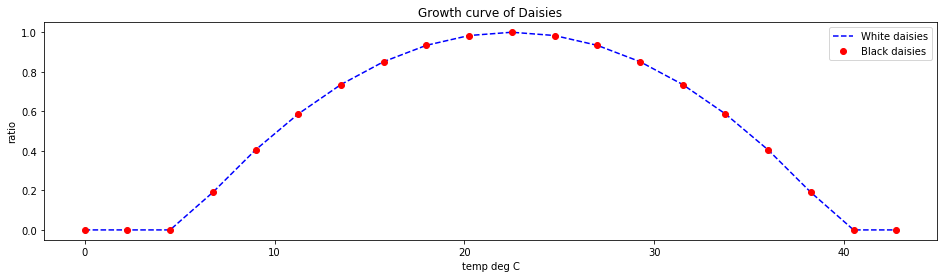

In [4]:
# get the growth rate of the Daisies

def DaisyGrowth(T,bwtype):
    Gw=1-((T-T_opt[bwtype])/(T_min[bwtype]-T_opt[bwtype]))**2;
    #set negative values to 0
    if Gw <0:
        return 0
    else:
        return Gw
## Intermezzo plot 
#how does the growth curve of the Daisies look like?
gw=[]
gb=[]
#amount of intervals to plot
nt=20

t0=0
t1=45
dT=(t1-t0)/nt
tempv=[t0+i*dT for i in range(nt)]

for t in tempv:
    gw.append(DaisyGrowth(t+273.15,"w"))
    gb.append(DaisyGrowth(t+273.15,"b"))

%matplotlib inline
plt.figure(1,figsize=(16,4))
plt.plot(tempv,gw,'b--',label='White daisies')
plt.plot(tempv,gb,'ro',label='Black daisies')
plt.xlabel("temp deg C")
plt.ylabel("ratio")
plt.title("Growth curve of Daisies")
plt.legend()





    


In [5]:
#function to update areas based on growth rate and death rate
def UpdateAreas(x):
    
    for Stype in ["w","b"]:
        grwth=DaisyGrowth(x["T"+Stype],Stype)
        ArType="S"+Stype
        Ds=x[ArType]*(grwth*x["Su"]-death[Stype]);
        # the following code applies 2 checks
        # (1) keep the area to zero if it has been 
        # articifically set to exactly zero
        if x[ArType] > 0:
            x[ArType]+=Ds
            # (2) apply the minimum area if the area comes below the threshold
            if x[ArType] < minarea:
                x[ArType]=minarea
            
    #update barren area (that what is left)
    x["Su"]=1-x["Sw"]-x["Sb"]

###  <a name="update-the-planetary-state-vector"></a> Update the planetary state vector
we can now gather the different functions to make a function which updates the state vector


In [6]:
def NextState(x,F):
    #make a copy of the previous statevector to work on
    xnew=x.copy()
    UpdateTemp(xnew,F)
    UpdateAreas(xnew)
    UpdateAlbedo(xnew)
    return xnew

# Experiments <a name="experiments"></a>
We now have the necessary functionality to perform the 2 experiments
## Experiment 1: convergence to equilibrium
In this experiment, we will maintain a constant solar flux which is 1.0
times the nominal solar flux, $1.0F_{s}^{nom}$. The initial surface is
populated with 1% white daisies and  1% black daisies, whereas the
rest is uninhabited.

Starting from the above initial situation, calculate the first 40
generations of daisies.

* Plot the temperatures $T_{p}$, $T_{w}$,$T_{b}$ ( on the Y axis) against the generation number (X axis).
* Plot the Surface ratios $S_{u}$, $S_{w}$,$S_{b}$ ( on the Y  axis) against the generation number (X axis).
* Also plot the variations of the planet's albedo $A_{p}$.
* How many generations are needed to obtain an equilibrium temperature (eg. global temperature changes with less then 0.05 K)?
* Is the equilibrium state unique? To investigate this, change the
  initial daisy coverage to something else (eg. 95% white Daisies or
  95% Black Daisies). Does the same apply to a situation where we
  have a solar flux of $1.3F_{s}^{nom}$?


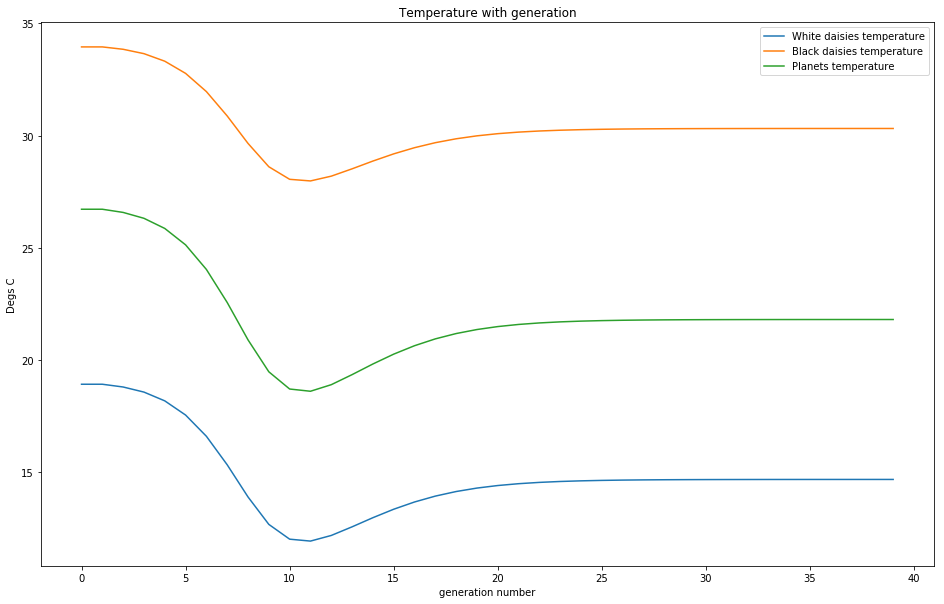

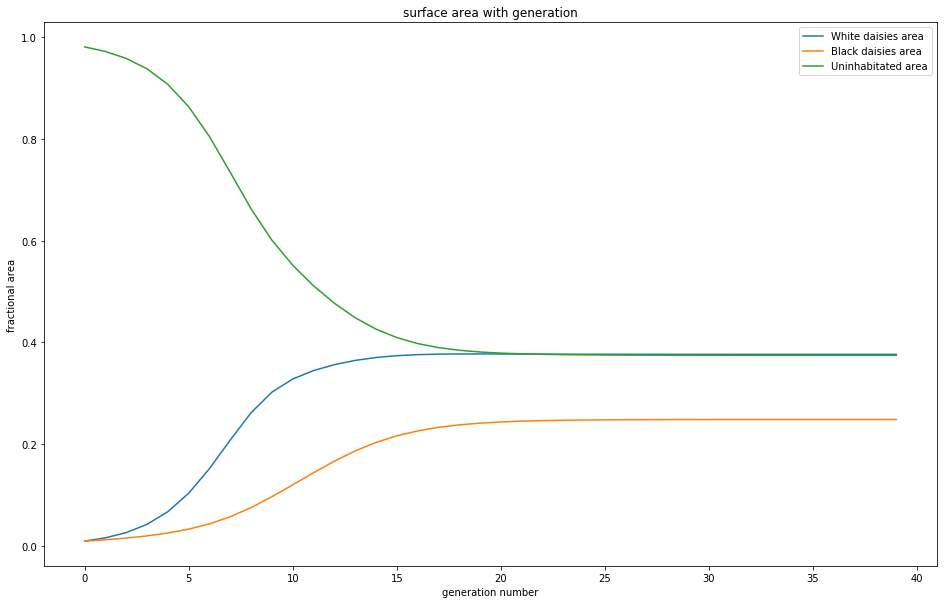

In [7]:
#First experiment

#solar radiation
F=Fsnom*1


#initial condition state vector
x0={}
x0["Sw"]=0.01
x0["Sb"]=0.01
x0["Su"]=1-x0["Sw"]-x0["Sb"]
#note that we also need to initiate the planetary Albedo
UpdateAlbedo(x0)
#and the temperature
UpdateTemp(x0,F)


#loop over generations
ngen=40

xgens=[]
xgens.append(x0)
for g in range(ngen-1):
    xgens.append(NextState(xgens[-1],F))

gens=[i for i in range(ngen)]


#plot temperature
plt.figure(1,figsize=(16,10))
plt.plot(gens,[x["Tw"]-273.15 for x in xgens],
         label="White daisies temperature")
plt.plot(gens,[x["Tb"]-273.15 for x in xgens],
         label="Black daisies temperature")
plt.plot(gens,[x["Tp"]-273.15 for x in xgens],
         label="Planets temperature")
plt.xlabel("generation number")
plt.ylabel("Degs C")
plt.title("Temperature with generation")
plt.legend()

#plot surface areas
plt.figure(2,figsize=(16,10))
plt.plot(gens,[x["Sw"] for x in xgens],
         label="White daisies area")
plt.plot(gens,[x["Sb"] for x in xgens],
         label="Black daisies area")
plt.plot(gens,[x["Su"] for x in xgens],
         label="Uninhabitated area")
plt.xlabel("generation number")
plt.ylabel("fractional area")
plt.title("surface area with generation")
plt.legend()




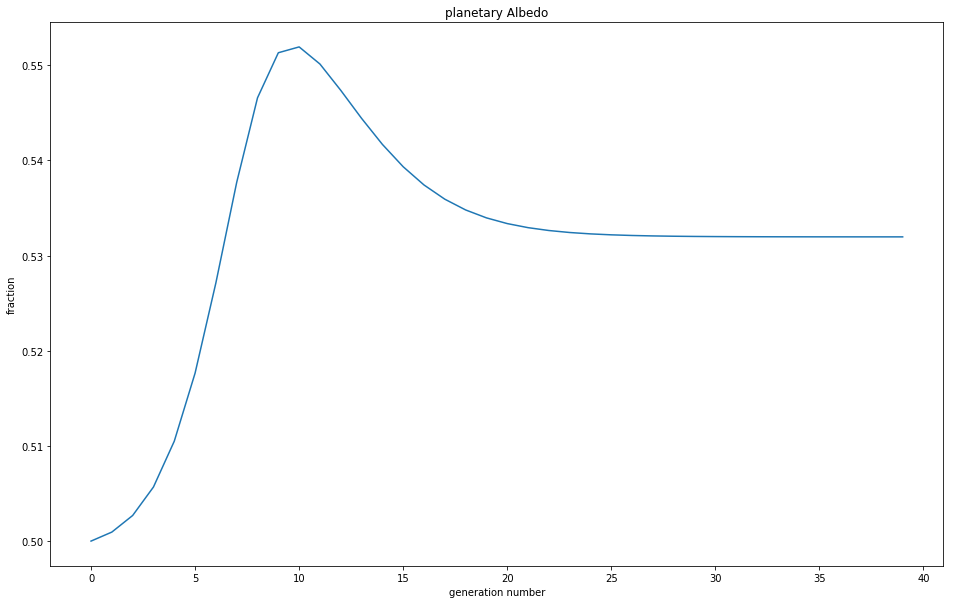

In [8]:

#plot the planet's albedo
plt.figure(3,figsize=(16,10))
plt.plot(gens,[x["Ap"] for x in xgens],label="planetary albedo")
plt.xlabel("generation number")
plt.ylabel("fraction")
plt.title("planetary Albedo")


## Experiment 2: Variations in solar flux
Due to increased activity of the sun, an increase in solar flux can be
expected during the planet's evolution.

Here we assume that the solar flux varies linearly from $0.65F_{s}^{nom}$ to
$1.65F_{s}^{nom}$ over 200 time steps.

Starting from $0.65F_{s}^{nom}$, calculate the equilibrium state of
Daisyworld for each of the Solar flux values.  Take as an initial condition
the equilibrium state of the previous step. For the first step one may
take the initial values of exercise 1.

* Plot the equilibrium Temperatures $T_{p}$, $T_{w}$,$T_{b}$
  against the solar flux value.
* Plot the equilibrium surface ratios $S_{u}$, $S_{w}$,$S_{b}$
  against the solar flux value.
* Also plot the planet's temperature as if there were no daisies at all
  (uninhabitated case).
* Which type of daisy has an advantage during the early part of
  Daisyworld's evolution? Why do you think so?
* Do the daisies have a stabilizing effect on the planet's
  climate? Explain why or why not.
* Will the curves look the same when the simulation is run
  backwards (decreasing Solar flux variations)?


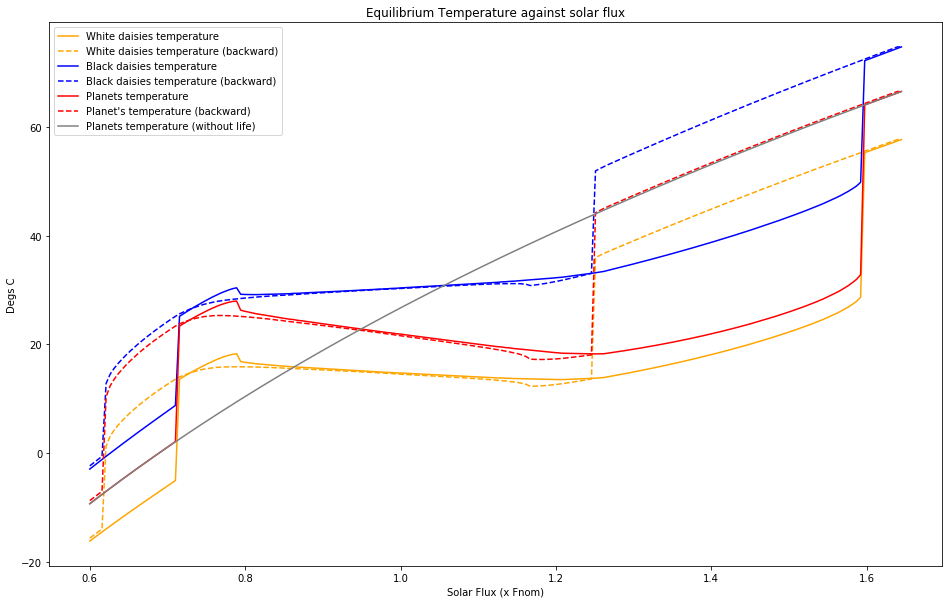

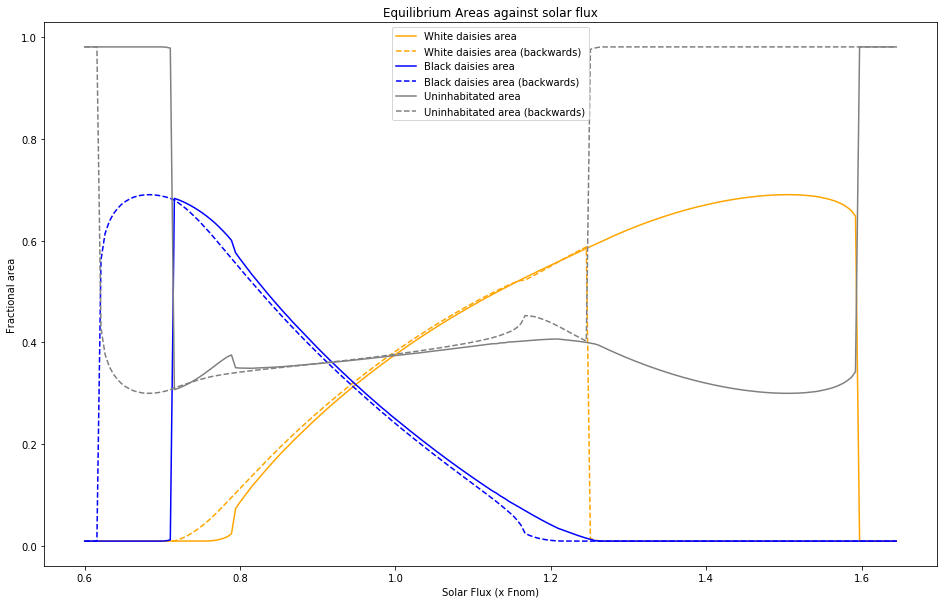

In [9]:
# To aid this exercise write and additional function which updates
# the state vector until  no noticable change in temperature is happening
def Equi_state(x0,F):
    dT=2
    x=x0.copy()
    temp=x["Tp"]
    while dT > 0.05:
        x=NextState(x,F)
        dT=abs(temp-x["Tp"])
        temp=x["Tp"]
    return x


#Experiment 2 Planet response to varying solar flux

#set up variation of solar radiation
nt=200; # amount of steps
Fracmin=0.6;
Fracmax=1.65;
dF=(Fracmax-Fracmin)/nt
F=[dF*i+Fracmin for i in  range(nt)]

#set up initial condition
#initial condition state vector
x0={}
x0["Sw"]=0.01
x0["Sb"]=0.01
#compute barren area automatically
x0["Su"]=1-x0["Sw"]-x0["Sb"]
#note that we also need to set the planetary Albedo
UpdateAlbedo(x0)
#and the temperature
UpdateTemp(x0,F[0]*Fsnom)


#initial condition for a barren planet
x0bar={}
x0bar["Sw"]=0
x0bar["Sb"]=0
x0bar["Su"]=1
#note that we also need to set the planetary Albedo
UpdateAlbedo(x0bar)
#and the temperature
UpdateTemp(x0bar,F[0]*Fsnom)


#loop over radiation variation
xeq=[]
xeq.append(x0)
xeqbar=[]
xeqbar.append(x0bar)

for Fr in F[1:]:
    xeq.append(Equi_state(xeq[-1],Fr*Fsnom))
    xeqbar.append(Equi_state(xeqbar[-1],Fr*Fsnom))

#also run the  experiment backwards 
# (use the end value of the forward run as starting point)
xeqinv=[]
xeqinv.append(xeq[-1])

for Fr in F[::-1]:
    xeqinv.append(Equi_state(xeqinv[-1],Fr*Fsnom))

#reverse the vector
xeqinv=xeqinv[::-1][1:]


colors={"w":"orange","b":"b","p":"red","u":"grey"}


#plot temperature
plt.figure(4,figsize=(16,10))
plt.plot(F,[x["Tw"]-273.15 for x in xeq],
         label="White daisies temperature",color=colors["w"])
plt.plot(F,[x["Tw"]-273.15 for x in xeqinv],'--',
         label="White daisies temperature (backward)",color=colors["w"])

plt.plot(F,[x["Tb"]-273.15 for x in xeq],
         label="Black daisies temperature",color=colors["b"])
plt.plot(F,[x["Tb"]-273.15 for x in xeqinv],'--',
         label="Black daisies temperature (backward)",color=colors["b"])
plt.plot(F,[x["Tp"]-273.15 for x in xeq],
         label="Planets temperature",color=colors["p"])
plt.plot(F,[x["Tp"]-273.15 for x in xeqinv],'--',
         label="Planet's temperature (backward)",color=colors["p"])
plt.plot(F,[x["Tp"]-273.15 for x in xeqbar],
         label="Planets temperature (without life)",color=colors["u"])
plt.xlabel("Solar Flux (x Fnom)")
plt.ylabel("Degs C")
plt.title("Equilibrium Temperature against solar flux")
plt.legend()


#plot Surface area
plt.figure(5,figsize=(16,10))
plt.plot(F,[x["Sw"] for x in xeq],
         label="White daisies area",color=colors["w"])
plt.plot(F,[x["Sw"] for x in xeqinv],'--',
         label="White daisies area (backwards)",color=colors["w"])
plt.plot(F,[x["Sb"] for x in xeq],
         label="Black daisies area",color=colors["b"])
plt.plot(F,[x["Sb"] for x in xeqinv],'--',
         label="Black daisies area (backwards)",color=colors["b"])
plt.plot(F,[x["Su"] for x in xeq],
         label="Uninhabitated area",color=colors["u"])
plt.plot(F,[x["Su"] for x in xeqinv],'--',
         label="Uninhabitated area (backwards)",color=colors["u"])

plt.xlabel("Solar Flux (x Fnom)")
plt.ylabel("Fractional area")
plt.title("Equilibrium Areas against solar flux")
plt.legend()



# References
[1] A.J. Watson and J.E. Lovelock. Biological homeostasis of the global environment: The parable of Daisyworld. Tellus B, 35(4):284–289, 1983.
